# Cluster Analysis

Cluster analysis algorithm
 - *DBSCAN* Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.


- http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- http://scikit-learn.org/stable/modules/clustering.html
- http://scikit-learn.org/stable/modules/clustering.html#dbscan

In [34]:
# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [35]:
# define the number of kilometers in one radian
## Earth radius is the approximate distance from Earth's center to its surface, about 6,371 km
kms_per_radian = 6371.0088

## Spatial Clustering

In [36]:
# load csv file 
df = pd.read_csv('asset tracking locations.csv').sample(10000)
df.head()

,_id,lat,lng,user,createdAt
57369,5b742c4f722de331f8cae136,35.299438,-119.624781,5b5a478ccd4efdb04c6e5139,2018-08-15T13:36:15.720Z
74821,5b76bd02722de331f8cb257e,35.257526,-119.601094,5b5a4814cd4efdb04c6e513f,2018-08-17T12:18:10.443Z
149876,5b8460a7722de331f8cc4add,35.223122,-119.616422,5b5a47d2cd4efdb04c6e513c,2018-08-27T20:35:51.265Z
440293,5bbe805ced55d20e1419f3b0,35.651871,-119.765790,5b5a4770cd4efdb04c6e5138,2018-10-10T22:42:36.254Z
339652,5ba55670ed55d20e14186a72,35.484434,-119.745219,5b5a4770cd4efdb04c6e5138,2018-09-21T20:37:04.116Z


In [37]:
# display rows in data set 
count = len(pd.read_csv('asset tracking locations.csv'))
count

468333

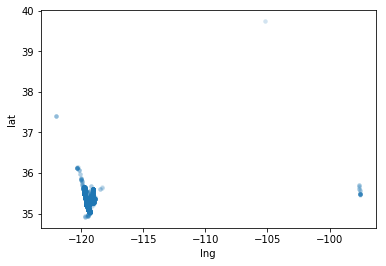

In [38]:
# scatterplot it to get a sense of what it looks like
df = df.sort_values(by=['lat', 'lng'])
ax = df.plot(kind='scatter', x='lng', y='lat', alpha=0.2, linewidth=0)

In [39]:
# represent points consistently as (lat, lng)
coords = df.as_matrix(columns=['lat', 'lng'])

# define epsilon as 10 kilometers, converted to radians for use by haversine
## https://www.movable-type.co.uk/scripts/latlong.html
epsilon = 10 / kms_per_radian

In [40]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine', n_jobs= -1).fit(np.radians(coords))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# find the number of clusters
num_clusters = len(set(cluster_labels))

matplotlib built-in colormaps: http://matplotlib.org/examples/color/colormaps_reference.html

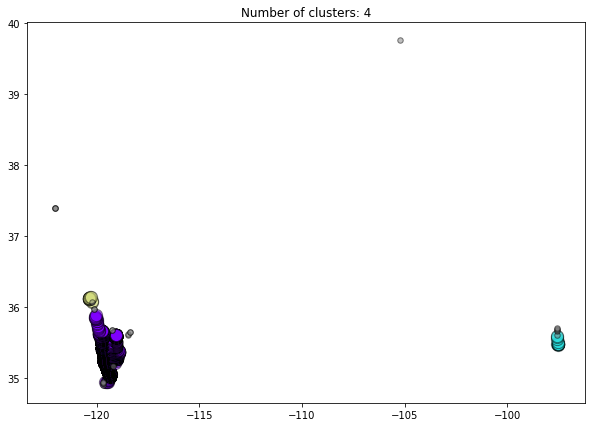

In [41]:
# use colors to plot points, color each cluster (or gray if not in any cluster, aka noise)
fig, ax = plt.subplots(figsize=[10,7])
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

##
# for each cluster label and color, plot the cluster's points
for cluster_label, color in zip(unique_labels, colors):
    
    size = 150
    if cluster_label == -1: #make the noise (which is labeled -1) appear as smaller gray points
        color = 'gray'
        size = 30
    
    # plot the points that match the current cluster label
    x_coords = coords[cluster_labels==cluster_label][:,1]
    y_coords = coords[cluster_labels==cluster_label][:,0]
    ax.scatter(x=x_coords, y=y_coords, c=color, edgecolor='k', s=size, alpha=0.5)

ax.set_title('Number of clusters: {}'.format(num_clusters))
plt.show()

The silhouette coefficient evaluates how close a point is to the other points in its cluster in comparison with how close it is to the points in the next nearest cluster. A high silhouette coefficient indicates the points are well-clustered and a low value indicates an outlier.

http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

In [42]:
coefficient = metrics.silhouette_score(coords, cluster_labels)
print('Silhouette Coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Silhouette Coefficient: 0.780


## Reduced Data Set

Clustering was used to reduce the size of the data set. Unless time is being evaluated, there isn't a need to have a bunch of points spent at one or close locations. 

In [43]:
# set eps low (1.5km) so clusters are only formed by very close points
epsilon = 1.5 / kms_per_radian

# set min_samples to 1 so we get no noise - every point will be in a cluster even if it's a cluster of 1
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))

Clustered 10,000 points down to 90 clusters, for 99.1% compression in 0.70 seconds


In [44]:
coefficient = metrics.silhouette_score(coords, cluster_labels)
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Silhouette coefficient: -0.676


In [45]:
# number of clusters, ignoring noise if present
num_clusters = len(set(cluster_labels)) #- (1 if -1 in labels else 0)
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 90


In [46]:
# create a series to contain the clusters - each element in the series is the points that compose each cluster
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
clusters.tail()

85    [[36.113006299999995, -120.37329540000002], [3...
86                 [[36.136641499999996, -120.3283503]]
87                  [[36.1369718, -120.28167890000002]]
88    [[37.39366373, -122.041409], [37.39367706, -12...
89                           [[39.754761, -105.221056]]
dtype: object

### Return the centroid in each cluster

DBSCAN clusters may be non-convex. This technique just returns one representative point from each cluster. By using the lat,lng coordinates of the cluster's centroid, the member of the cluster with the smallest great circle distance to the centroid.

In [47]:
# given a cluster of points, return the point nearest to the cluster's centroid
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

Geopy's great circle distance calculates the shortest distance between two points along the surface of a sphere. https://en.wikipedia.org/wiki/Great-circle_distance

In [48]:
# find the point in each cluster that is closest to its centroid
centermost_points = clusters.map(get_centermost_point)

# unzip the list of centermost points (lat, lon) tuples into separate lat and lng lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
representative_points = pd.DataFrame({'lng':lons, 'lat':lats})
representative_points.tail()
representative_points.tail()

,lat,lng
85,36.118910,-120.371476
86,36.136641,-120.328350
87,36.136972,-120.281679
88,37.393677,-122.041405
89,39.754761,-105.221056


In [49]:
len(representative_points)

90

In [50]:
# pull row from full data set (df) where lat/lon match the lat/lon of each row of representative points
# use iloc[0] to pull just the first row if there are multiple matches
rs = representative_points.apply(lambda row: df[(df['lat']==row['lat']) & (df['lng']==row['lng'])].iloc[0], axis=1)
rs.to_csv('reduced-set.csv', index=False)
rs.tail()

,_id,lat,lng,user,createdAt
85,5b720780722de331f8caa58d,36.118910,-120.371476,5b6b0e789e6b212e45d068d2,2018-08-13T22:34:40.309Z
86,5b720952722de331f8caa5c3,36.136641,-120.328350,5b6b0e789e6b212e45d068d2,2018-08-13T22:42:26.295Z
87,5b720a03722de331f8caa5d4,36.136972,-120.281679,5b6b0e789e6b212e45d068d2,2018-08-13T22:45:23.303Z
88,5b6f5a7e722de331f8ca7f99,37.393677,-122.041405,5b57cf461574dd2ea2cd4fcb,2018-08-11T21:51:58.760Z
89,5b58fb50033f7408b735b0f0,39.754761,-105.221056,5b58eac216bb18644345cace,2018-07-25T22:36:00.497Z


<function matplotlib.pyplot.axis>

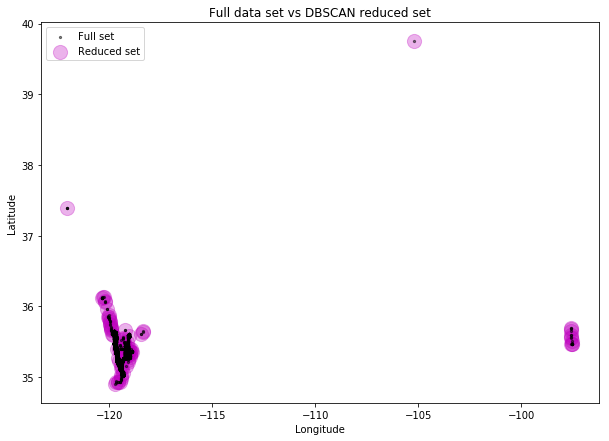

In [51]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10,7])
rs_scatter = ax.scatter(rs['lng'], rs['lat'], c='m', alpha=0.3, s=200)
df_scatter = ax.scatter(df['lng'], df['lat'], c='k', alpha=0.5, s=5)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper left')
plt.axis

[-121, -117, 35, 35.7]

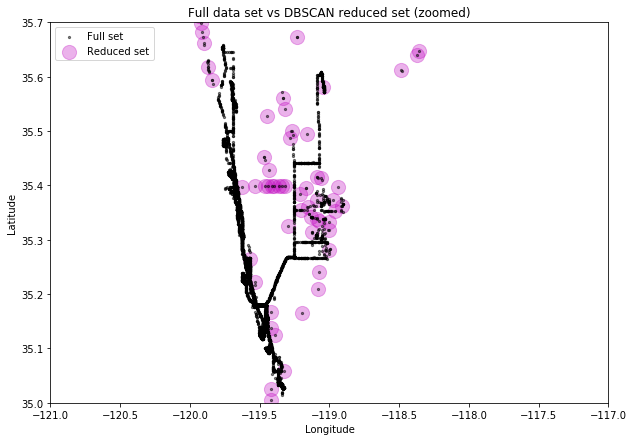

In [52]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10,7])
rs_scatter = ax.scatter(rs['lng'], rs['lat'], c='m', alpha=0.3, s=200)
df_scatter = ax.scatter(df['lng'], df['lat'], c='k', alpha=0.5, s=5)
ax.set_title('Full data set vs DBSCAN reduced set (zoomed)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper left')
plt.axis([-121,-117,35,35.7])

[-121, -117, 35, 35.7]

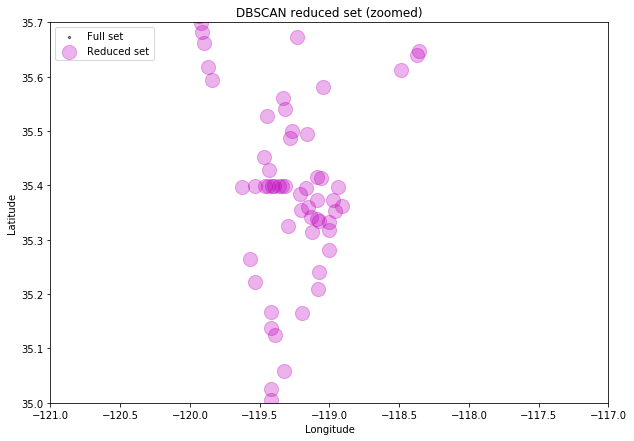

In [53]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10,7])
rs_scatter = ax.scatter(rs['lng'], rs['lat'], c='m', alpha=0.3, s=200)
ax.set_title('DBSCAN reduced set (zoomed)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper left')
plt.axis([-121,-117,35,35.7])